In [2]:
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

In [3]:
# we can get its mass, half length (r), gravity constant
print(f'm is {quadrotor.MASS}')
print(f'r is {quadrotor.LENGTH}')
print(f'I is {quadrotor.INERTIA}')
print(f'g is {quadrotor.GRAVITY}')

# we can also get the integration step used in the simulation
print(f'dt is {quadrotor.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {quadrotor.NUMBER_STATES} and number of controls {quadrotor.NUMBER_CONTROLS}')
print('the states are indexed as follows: x, vx, y, vy, theta, omega')

m is 0.6
r is 0.2
I is 0.15
g is 9.81
dt is 0.01
number of states 6 and number of controls 2
the states are indexed as follows: x, vx, y, vy, theta, omega


In [4]:
def plot_result(t, state, u):
    # we can plot the results
    plt.figure(figsize=[9,6])

    plt.subplot(2,3,1)
    plt.plot(t, state[0,:])
    plt.legend(['X'])

    plt.subplot(2,3,2)
    plt.plot(t, state[2,:])
    plt.legend(['Y'])

    plt.subplot(2,3,3)
    plt.plot(t, state[4,:])
    plt.legend(["theta"])

    plt.subplot(2,3,4)
    plt.plot(t, state[1,:])
    plt.legend(['Vx'])
    plt.xlabel('Time [s]')

    plt.subplot(2,3,5)
    plt.plot(t, state[3,:])
    plt.legend(['Vy'])
    plt.xlabel('Time [s]')

    plt.subplot(2,3,6)
    plt.plot(t, state[5,:])
    plt.legend(['omega'])
    plt.xlabel('Time [s]')

    # we can also plot the control
    plt.figure()
    plt.plot(t[:-1], u.T)
    plt.legend(['u1', 'u2'])
    plt.xlabel('Time [s]')

## Part 1:

In [5]:
def get_linearization(z, u):
    theta = z[4]
    u1 = u[0]
    u2 = u[1]
    m = 0.6
    I = 0.15
    r = 0.2

    dt = 0.01
    A = np.array([[1, dt, 0, 0, 0, 0],
                  [0, 1, 0, 0, (-dt*(u1+u2)*np.cos(theta))/m, 0],
                  [0, 0, 1, dt, 0, 0],
                  [0, 0, 0, 1, (-dt*(u1+u2)*np.sin(theta))/m, 0],
                  [0, 0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 0, 1]])

    B = np.array([[0, 0],
                  [(-dt*np.sin(theta))/m, (-dt*np.sin(theta))/m], 
                  [0, 0], 
                  [(dt*np.cos(theta))/m, (dt*np.cos(theta))/m],
                  [0, 0],
                  [(dt*r)/I, ((-dt*r)/I)]])

    return A, B

## Part 2:

In [6]:
# Part 2:
# solving for infinte horizon LQr to get u=k.z which will stabalize system

def solve_LQR(A, B, Q, R):
    
    QN = Q
    N = 1000
    list_of_P = [] # K will be from 1 to N-1
    list_of_K = [] # P will be from 1 to N

    list_of_P.append(QN)

    for i in range(N):
        K_1 = (np.matmul(np.transpose(B), np.matmul(list_of_P[i], B))) + R
        K_1_inv = np.linalg.inv(K_1)
        K_2 = np.matmul(np.transpose(B), np.matmul(list_of_P[i], A))

        Kn = np.matmul(-K_1_inv, K_2)

        P_1 = Q
        P_2 = np.matmul(np.transpose(A), np.matmul(list_of_P[i], A))
        P_3 = np.matmul(np.transpose(A), np.matmul(list_of_P[i], np.matmul(B, Kn)))
        Pn = P_1 + P_2 + P_3
        # print(Kn.shape)

        list_of_K.append(Kn)
        list_of_P.append(Pn)

    list_of_K.reverse()
    list_of_P.reverse()

    return list_of_P, list_of_K

z0 = np.zeros([quadrotor.NUMBER_STATES,])
u0 = np.ones([quadrotor.NUMBER_CONTROLS,])*quadrotor.MASS*quadrotor.GRAVITY/2
A, B = get_linearization(z0, u0)

Q = np.identity(quadrotor.NUMBER_STATES)*1000
R = np.identity(quadrotor.NUMBER_CONTROLS)*1

P, K = solve_LQR(A, B, Q, R)

def infinite_LQR_controller(state, i):
    u0 = np.ones([quadrotor.NUMBER_CONTROLS,])*quadrotor.MASS*quadrotor.GRAVITY/2
    u = np.matmul(K[0],state) + u0
    return u

# infinite LQR for steady positioning without disturbance

horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
t, state, u = quadrotor.simulate(z0, infinite_LQR_controller, horizon_length, disturbance = False)

quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAb4G1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAN72WI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0AKyEiQN
GoF960K8QBVQ5o4JP/2cuv2ZMrH9QQZc0jHnLNGnVOHM8XVrtwE5+h5X2tZb0yVcBXic84ErblKT
JbTq4Hd8Yl3kcjYo0GwN0gX5v37991BsXCcYw2mayGViX7BEgxkPtwf//psTT/eDe8rLOmldMX+X
tWN3jEkYZZzhIObepWqsJ+HoYBGdkTf9P/7uKEXXC2I74+6w0Zx+XG+zlXFXgwxm5Qz+KIqvNFkD
lUP5L0XF+hp7Uk8n9kpANbcgjSMpLW7m5TbNsYTwsM95H9qz+EvI708ahHUu6vK+1J58JMjWbbIn
Zn4IBKAAC7g6U1KoDtjcnP58qNj/JoDC5fVtr+A2m5QAIeNCly0DokANHk14UjVOPHT/bRdMMLhc
HeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/wpFNJwCw
3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+Lnk+q+lQ4
eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmoYuC6VeG1cCu4Xv2VqNhL
gJbIE/MAN9GWy8MVq3JKMY05hpbR65Dk/eLsdAxzBAr2oVxGFkT/PhGfZthbWxjPO1OT5VOuHlGm
wU1d1p7J9Af9kY7lGkBHkYrI4yusPcYU4XXkiBBXmfdpxQAAAwC1CZjMyK5c22YBdQlKgl1KkcCs
RxULvj07lJvaE/1ct0s6EBTwzE+UWupyGTX9vO345aNs/wNQ/4V1buvVOI0dQeS4BxhhX5mv0vM2
JtNBWPRyaS1ECKPL6/MdozqIzwP6cnd+HHSisYEZeG0gIqUymPTnr1IxP/pBgmgm8BFStWTTHjLM
xQ60cYl1K4e1m3hC1onBHBwxxfWgha5UF0IMM7kaLaR+4aoPADApQhIzR07n9XFZae/M2xV9fAVm
wZw2MimGG+s+AyO59vHrTaHisD7u+EkA3Ul/6VA0wSQX49hJgXZ/W9lWxysKFt79X7H/yAfTI/kR
453FbNp/3gKU6XOuXYELBUYCR677xzJY8jBmACGX1+MAeK/zsGszd6cnq6six0ScJrA/yQ6gVCJw
1FHsT1/eYLuxwnwq2FjG2KGOOJ3k/H5hb2yUgcAywdjDyNNVP/+5WjXxTwGKM39c6h3KsNG3BKR/
2f5Zm94NXMcR2btFeVoHe+lqFGdc3Rur0KNjhGNCWhpWEMw8pssX+KCzr9LrG37Wwf24qaaCTw0Z
/z5A32oReNpWIzxpovi6haz8Nlkcnr06H6R82KmIgEVY99sRr3Z3NcU1+paVGtEGQQFNJIhInRGh
c/3O83FL0wB9atlmwQBliczEIIhWGfey62SSqXrN+y7TbOev5m2fTR6f9035XZ03Uxa/CRqZblYr
p67J/TU1llHj3GYgsn9rVySApcAAAAMAAKrY7HyweOH8EDYUCbez32wZPywTpX2kzm2LOGkNttkq
ymhACp3M8n08RKxmZb8//wmpxUxrZS5tGO01N3L8GTQsV9WbSpyGc+HI4UaBU0lB5icRB938RuGF
tpvy/6UE+pcZDSdZ9ZV3LnePpOiGgVppfHsLNiJ7g+0DuaH0wUFkeXiePQ+paC5zVNth1eiJ2z6v
Z15KnO1HlHFCLBgPqdmsXoUvdsHLv4HW1BuqaJb6nSG+tG4QNd//6jMG5porq4rIH4gEHznlQ/aK
X+Pd8MKCoPkxk9WYaT8UskIeMG2/Nn1AAnAVHzALbYRLToarb8U1s2i0L0z85+6z/IhcPqcwFLgG
9ZvJNGW6vYmsWQEZSqPnYVl8ZXHVG7/Qc2KFX1uQLNEJGx35q8kSEeBhLRVHIMnHBYxBUXAMmSX2
14jVkGJWXA0/1oubNqy5DoV2rawN9XbCQwjaYjstrYxWzgyWKDU9G6i18A8ObXSOcj7F+L0Jv/Z/
X9+8R1y07fhwO1+hIZyOigbu9Rh8QoLA8JOvVXFRg7tTdburYjI6EL5EKM3cjY6x3Bewej1ovSbx
gYxCGRPO0X/OJicaMmBoYA1+b0qU/hpsq4Xso9Mr81wBWYsPq+qnkbvQr+RV5aghN2kjmYebNBxN
xc7Y6HjdBEUkim4WAAI1xrjF54xnmwAwY5AAAARtDvt1MUiW62w7eglcgXzKCb8L/pClD7maJgGu
lu/L2hree7YVfPxHsgcLqpNSTJtrDF1vOB9wxA7XeFPCp+wJv1INpFfTR9Ct2AK08mbqcjVL1p5J
Uq0eIhsmaK9VzKK6RDFrpF1zNOGGdol2XAZ2tx8rLOPy52+Kx/cdiqf0G4Tq+bCpXdGETU/+GzZP
zqu3sNL+IP8dmk1jCpL36GxNF1LEXm5nmeImhziTeUPcMfXOWsrnPjA13TgzQEfQlUQFA0UUryfl
RHQssz9XmonixyZOCNh8tKBetGD8X7Y+k4k82/N1r7jd92X26BSqxHfj6Hw5euPfVlIo+gS9+pua
spiuJV0XdRaRz82FTk4LHDYjz34VbgYjIr0viZP6VsPgyOuOgro6AAADAAADAg4FyGJEfGbOaqnI
LPPeo+F9xM1/dIhEujPTtuk4tz+HgXYKLCEx5hm3gLK/+4ND7QMKrlfjHPhQ44WhdoRQhHvLrN/K
oNqfWZEAAOQ4LMopqsnR0lvoiq5s2ocIOhXpm6kbFfrN5BA3mrRFsiPvljD+bjjODbxDBCGWbFlZ
Le4Rw9rIWeQsXD/tx0Tbj5vWSS4pfFLn+1+hIZyOjHkzmS/yG0aRNv1sLi/dPPFeDb9vqGLGeqdA
xmCwBl1YLm0o5B23YkldU

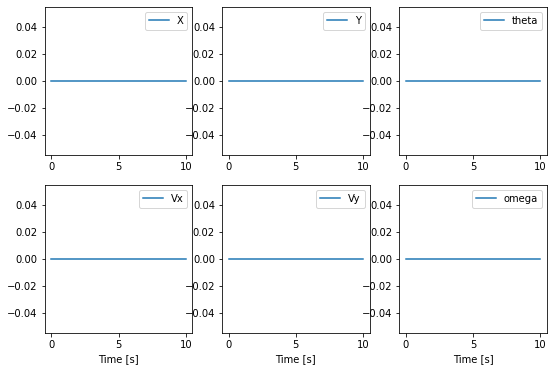

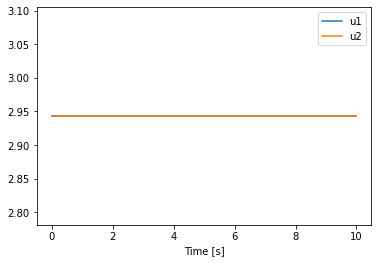

In [7]:
# plot result
plot_result(t, state, u)

In [8]:
# infinite LQR for steady positioning with disturbance

horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])
t, state, u = quadrotor.simulate(z0, infinite_LQR_controller, horizon_length, disturbance = True)

quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABBlW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAN6GWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0AKyEiQN
GoF960K8QBVQ5o4JP/2cuv2ZMrH9QQZc0jHnLNGnVOHM8XVrtwE5+h5X2tZb0yVcBXic84ErblKT
JbTq4Hd8Yl3kcjYo0GwN0gX5v37991BsXCcYw2mayGViX7BEgxkPtwf//psTT/eDe8rLOmldMYEH
c6oj5Y+lHShjvew4YzHn3hefC2vqjbplJ68h//dx4ZTIH1BVgKe6McmgG49sDid6Yq5tA2cTF3RY
1dVpzQNHA8SP9eIwctx4qZge1K0igJwr0MPsN+EmvCqsCeGeCH3kV8k8CY36bIOcUTaAO9jF2gX6
Y3w68HBDb/bLnCHNvRP6bEPJELLFq0ocECwny0iHAABGTxRdiRLmK/7M2wKngkFAQvu02kZCEV4+
JMYSoAYyGnP9aX1y2bquTEQ7Nd8BtRTcvFsZPaIgpc53Lwhztnn5Vpr3p1X5wqyW1mxGtQj4abet
F01cmL9O+j4ngz36se3FNYcztZ5eJ85Oje+zL0lL7HHgOHPPUQa8ShgvdZw1s3/m8ux2KtvwcCiO
26Hp3aSN2MqaSfceDcQfRjTyWsGuLo4KJc22S5A1/8tBIicI81ALem1Uc1luQCjhDuW/KNLo0iEv
Iz+KWeEfUGw9AEj2YXC6FOJbjOW4a2PtKYAw9PXPA1ErckoxhibkA5y/HNM6urLdifiWLen99tBD
xQUwaGVCHIuZgmkN7ChF5PvcNuKKf0s9lYnuskgYx3KNICPJhyyOMrrD3rAhDvP/5QAnlj6BIN7o
tKQAAAMAMUAS3Dd9u9bhYSQEdSQ70wPXUSYylBeNY3TtzNLR909ZbpZ0CGoaGJ8otdTkMmv7gdvx
y0bZ/gah/vp8mP9U4jR1B5LgHGGwWma/S8zYm00FXvYWGdaMWV6Y06aoRxJby2qcnd+HHSgPtxGn
d8REVKZTHpz16kQ3/sBKLQdaAe+AhW+OZ+UhQ60bOMbeTS/LqN8DOBEcHDHF5xn3HM/KwgwzuRot
pH3neJOHwAKEJGaOnc/XXQcWPcll9q7KCMFaayi0S295fL+g4ZIKnzQi5qQsLj2P4IXbYWn/n3u3
e0vwbw5ii7P63sq2OVhQtnSMrcZaEmzrCpL6XMiVLpIEPgAQsBE/E14OJ2Wg7L8AAAMAAA5WmENU
0GPP6ag26luqHOdQw976KR5hkt4iR55Fm2hgu7HCfCpatmGJU/J5qzpyx4xNkyFPxkeFOMPHuPU/
/7mtQ+VIlhYjltuEr7WDj3EoWgHx++c3zvn7U4wuCy1Tf6KzKU95/XOFvOpSIIbx1XIIhQHwAXFN
li8fs+ZXF1qo+MAdkwgRRu3fIP/nxBvqitgKg2cNv6J+5j/jopllkcnr06H6a9Qp9UrIyBLHX3f8
P0mASNfVTMqnxfsjk9enRBbMD5SRQSAp0tWoB5BS2gasxzWWupl8qQAimD8IkcGLFoXGpWo9/RSD
TauWJF7+epxvVTwexPirtZb1j6BDuOQicYxHiBrtB5Y+qQuAHndiYdE3572So7kPh7AAAAMAzwCD
7qugFRNW/lSiATkSXuDg4VBoCY7OzK96ZL4p8JZUtApRK4bVHpB9a84vudwvaP/ykZKuba4JZ64D
/ut/6Nu80A/BZ6uwvM+tvqdtgQ9Q2YUwIgqrsH1gUFcTzJWjbBeEsGtqspyGWt42VErBp6AH/q0R
a3g5nWp/eK9S1eL1D9VusgEwHVe0OoGpqE9ClOuzAk28t3dWE+qd2l5gZyttETi9yCmn+4vviqFc
VLtay//mcAnJZv/ykWvzSolzqS5nEtOzBoT3+UNK8kFDrTp/fogsooVWMWhSidci2rabyFuDsfEj
AUQsHV5SyJmJOJJZmJXUaG8TRMIkVCr6DEhrrVCEznKmGzuzejk09angkxzOlVk6uWwSDKbobbgg
XX2eoU61NQcQpy5DoV2nSwtoOZiyP1Nxgj/tzFgwQ1rXSrRH7mQEbM5BSARN4FL8XoHf9jpNvMq9
boK2bXF8bIWU1I6KIVfzypowgL8j/0N+3eW6QFNrpVB6ackecqEXTrwCxdB7e9ICIhdvMUBDKeGf
ZWGi1lprX3Mct3Jdd5oe2MYZQG+E8TQPoyKdUDYb+R0X5JiXncue7lZLadBAHTpjEmc9hPzfAB3p
hysycUeHb+51oOSwUJPROIxBZDypouj80v4fOGO3tsAAAAMAsQAALmqq0j/Ot5i5ayX1BiyBfMoJ
wSP/MDWlGjiStHkUgVphmc1TiuHDD4jyoqSdiDsf821hi63kaAJgD9XeQlTUFP1F3fgul3yTiro0
Q3Ft+miKRql6U+LwABtdtYVyhVHRkmm5wlkdWHv5/woek8/UK4U5sMtgzNqCKZtjCuMx3h+GNZ05
EMaT/WhgjuXCiXAXMr+uFqgWR/rI3sKS70wC9YgXAksRebmeZ4iaJ0YowzOgDl/ksaTe8LHkdpJN
qs/upw0DGjcYXCileT8qI6FpWiajyjKE5OJwRsPlpQLglcaBRAu6XEnm35utfcYzhRf3p70WKQ74
buHL1x76spF8OFl0mZQ/omQi5TXlfTDQhvpL0i4wAAADAa8k7ET6og28zGHcRQRMtpCq1dB/dDmH
2/Rtk0lhQ7q3pX3kZUw/JKG+i8u/+weAFYIKsXjUJUWKGbaTAcKqmkyIbtnh3btaFpTkGblx8IK4
DzA3Ln80RVc2bUOEHQr0dtY1lnxwAAB5WkwUK0uukc2jDx3Dor3jUeTau6hl+XFdfAtGbNHJxv8R
AMws1pcCYZWOwfXfFlFtkix2kRDk0ffc5vZQZc4kY0p+zQFDiyTpYXvQvZFBEPhuSEx65dFyr38V
pnw4XFszZben+8UqWmOGs

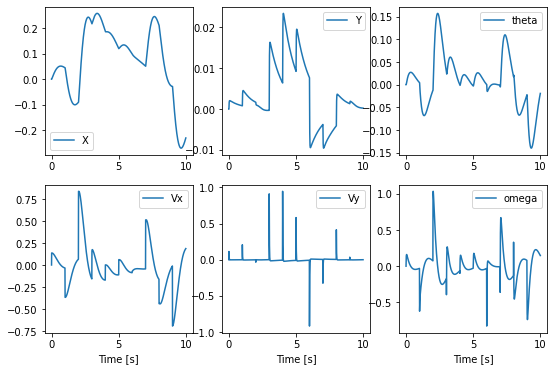

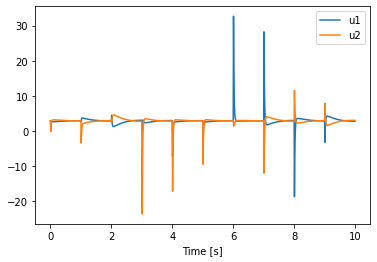

In [9]:
# plot result
plot_result(t, state, u)

## Part 3:

In [10]:
# Part 3: Following a trajectory
import math 
N = 1000
global z_desired 
z_desired = np.zeros([quadrotor.NUMBER_STATES, N])
radius = 1

t = np.arange(0.,1000*0.01,0.01)

for n,i in enumerate(t):
    omega = 2*np.pi
    k = n/1000
    Zbar = np.array(([math.cos(omega*k)],
                     [-0.628*math.sin(omega*k)],
                     [math.sin(omega*k)],
                     [0.628*math.cos(omega*k)],
                     [0],
                     [0]))
    Zbar = Zbar.reshape((6,))
    z_desired[:, n]= Zbar
    

z0 = np.zeros([quadrotor.NUMBER_STATES,])
u = np.ones([quadrotor.NUMBER_CONTROLS,])*quadrotor.MASS*quadrotor.GRAVITY/2

def solve_LQR_trajectory(A, B, Q, R, x_bar, N):
    K_gains = []
    k_feedforward = []
    Pn = []
    pn = []

    Pn.append(Q)
    pn.append(np.matmul(-Q, x_bar[:,-1]))

    for i in range(N):
                
        # Linear feedback
        Kn1 = np.matmul(np.transpose(B), np.matmul(Pn[i], B)) + R
        Kn1_inv =  np.linalg.inv(Kn1)
        Kn2 = np.matmul(np.transpose(B), np.matmul(Pn[i], A))
        Kn = np.matmul(-Kn1_inv, Kn2)

        Pn1 = Q
        Pn2 = np.matmul(np.transpose(A), np.matmul(Pn[i], A))
        Pn3 = np.matmul(np.transpose(A), np.matmul(Pn[i], np.matmul(B, Kn)))
        P_n = Pn1 + Pn2 + Pn3

        K_gains.append(Kn)
        Pn.append(P_n)
   
        # Feedforward
        kn1 = np.matmul(np.transpose(B), np.matmul(Pn[i], B)) + R
        kn1_inv = np.linalg.inv(kn1)
        kn2 = np.matmul(np.transpose(B), pn[i])
        kn = np.matmul(-kn1_inv, kn2)

        qn = np.matmul(-Q, x_bar[:,N-i-1])
        
        pn1 = qn
        pn2 = np.matmul(np.transpose(A), pn[i])
        pn3 = np.matmul(np.transpose(A), np.matmul(Pn[i], np.matmul(B, kn)))
        p_n = pn1 + pn2 + pn3

        k_feedforward.append(kn)
        pn.append(p_n)

    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward

z0 = np.zeros([quadrotor.NUMBER_STATES,])
u0 = np.ones([quadrotor.NUMBER_CONTROLS,])*quadrotor.MASS*quadrotor.GRAVITY/2
A, B = get_linearization(z0, u0)

Q = np.identity(quadrotor.NUMBER_STATES)*100
R = np.identity(quadrotor.NUMBER_CONTROLS)*0.1

global Kt, kt

Kt, kt = solve_LQR_trajectory(A, B, Q, R, z_desired, N=N)


def circular_trajectory_controller(state, i):
    u0 = np.ones([quadrotor.NUMBER_CONTROLS,])*quadrotor.MASS*quadrotor.GRAVITY/2
    u = Kt[i]@(state) + kt[i] + u0
    return u

# Trajectory tracking without disturance

horizon_length = 1000
z0 = np.array([1, 0, 0, 0, 0, 0])
t, state, u = quadrotor.simulate(z0, circular_trajectory_controller, horizon_length, disturbance = False)

quadrotor.animate_robot(state, u)


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABQnW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAOCWWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0AKyEiQN
GoF960K8QBVQ5o4JP/2cuv2ZMrH9QQZc0jHnLNGnVOHM8XVrtwE5+h5X2tZb0yVcBXic84ErblKT
JbTq4Hd8Yl3kcjYo0GwN0gX5v37991BsXCcYw2mayGViX7BEgxkPtwf/8NZ3l/tTJtQPbvcAMqE8
X4CF32uFqL9M6IDuRxOQzD3BBKsdz/80JxuZbQFe6FcA1Tx4uTBfm3X2bVGRI/1zXf0vRer/+cP8
Q54GahqWxsw3nK3NHSdaEEmwIv9LFWl3D7TrwaB/lr8vDFo2BJpvZWP8Fu3AvEHXYxxfd4/RHEGn
HGmMlzynv8n6KRxeL8y8HTcPc3njsOiwDAMY968B4npFPIetTKj8gIKTb59txdYv/KGPC2p5ZEt1
cCI4ebftyJHO1TRTf79WARhdOf60wD5UYMWmIh2a74Daim5eLYzj0VBOdxib03O2eflWqedOq/OF
WS2s2I1qEfERLsRdNXJi/Tvo+J4S4yDb/CkU0nALF0n0Bs9juzxaH02BvgLu0/i42Txcqq8fQ7s6
C+A7if6H0RKXbdD07tJG7PdiK/ZwXfFRr0vN8UJ7xdHBRLm2yXI0N/rwqVYIyToBV8P/fJrGrAUc
Idy35RpdGkxl5tfxmSde82yWLM2rgV3C9+ytRtYt1aJ96UsjmSSJNTd/gRJRjGXf5bZF4WXp1Uzv
zE/EsW9P77hCHigp2XMp/OViif1sD9ZIYOf/k3iXqyJzgNVbQeSbjEsbcvo0sXcUCLJf/cKQ46gq
GQAAAwA/gAY/lL37YgBBagL4X1Ius3j6mMl5tlYGWWK8wOuf16CDPgpz44ZIciuFvvZk0EHFtPAI
FtWZQRiq3p+YRJoEwFMmEbgHGGpVYyXuZzjTU0FXoMHj7v4Ee9umGlyuTZirtq5O78OOlCvbiTjR
aas7TUkPTnr1LJ//hCZDx76U9QJjSjHjLMxQ60bPMbITi/MD18DOBEcHDHF7Fn3HNBiGUWP1tYc5
Wp0LEnH8AFCEjNHTufssHbaYuSy+1dlBGCtNaJaHVbYwGR3PvtPhT43rEiraCqT+1dN9Ng/8jeYS
tq9kkKVgXZ/W9lWxysKFt7MPwssmlTrJHzWCQYAVicFYWXBzPMEcyAbiMHnuOLLHoWmthAAHsYQU
gEykS1BxJm70+sd0Gl9UOc6hh730UjzDKI9KdFhX/3mC7scJ8Ksp4xtihjjid5Px+YR9slIHAMsH
Yw8g9GYf/uZlD5UiWFiOW4AUvtYOPcShaAfH8+yvYaTXI0vN1m2+UI1WxPw+ucOWJbqAx8QjQloa
VeXZRIQRx1wx2dfqygRuPGAOyYQIo3bxWb/z4g31xchpQWR/L5O/czQH5+GyyOT16dD8qQJy/SpO
mhNUuckVQTk+L9kcnr06ILbdYaSJvicjduEhQZKOe+ULL0sY+D6teYHYPB4FTZq85u0AHSvxi5kD
Iir6isFRAhbNR/O0xXS0wGqXz5C7s3eZ/RWg05kKBtVjiTgMw9y2xg4OI+HuzjabXPua5Fu62vzY
kaCBu/do3gAHn4AV7GQ8EKqfyWYXXNoLDvqW1Y5OY2yMxrnDxgjboO3aNnQFNXUUwbJzjW7TTLD6
cddHCAA8AsHxbWx/6OqhTeLwiY6MWpoyGq1QrOG0kspVZPYupDT/WxNfXmYPe3UsH+GOUK/qPf+O
HdwSHb/i++jYfPZb+63izhpDbbZH2GPNfr7N0PkTqS3/mYCDwkY0fj8DSlQm1fzYxE/nyyGgFKrG
BAtecugKMLGBH5xG6F3Qf+b/5Ivx6J8fDywDAK+07FiYeNfw1RMF0h66FJnRVwx+DKBeMQtKBcF6
vihkTKVnDjPhSp8lW3qb5/KoVs+r/2sx8fjYFXrUujXidIeMh/xZB6tq+XrVCEoZaJtwJu5VcbrI
sjC50xne8w5nX9PAnXM9rGKv4ykKoo2xcyc8CERECkbLA8yQifY5B84Zt7fN3cvR+nmCpOgrHJRM
XSOSF9PcNLYjjlsk5ev2MOwguzddYY6rjOdrXSrRN4Q+6Utm47DYMlFjC3vif8ii/y+k27fjJt91
7qgbyGcjoAUl4rGzMfr0eMhJhRzmYZg7AfDSN7uY5dkagFV6+ZQGQ1y47JU4FbyEnSStoQQg+8m8
dDCAc3+KVCQFiFs1FKk+IBqHRmXHkF8p7OVQLAGmYyw2dykR8dIUvTe4O3ki1TIelKGlZ5ea5QAA
CsfBeF+hAommcgAA51dxK5QVvp7lVvNfC4V5t22w9if0ANaUXQpCQth93mTSLzvCrQwc+ZzA6i6U
e81JMm2sMXW8z2D0yDf43o6OMT9Rd34Lm/7GJT8vOghTob3QZGqXoE+Np1o8RDZM0V6rnoC65wlk
dZY3fb4T6ue7Mj3dALczQY92s+H4Y1nTkQxpI3bvHRH9KzZPzqu3sNMII/zUb2FFeb+sIbB44ksR
ebmeZ4iZkTMCbtoMJElNTsTe8LKUNkkNmNzQ40Lh/EUUryL0tzItGWN7uK/raMwAmJwRsPlpPvye
5+NQCxM7EX9/JPNvzda+4t8Ch7mKN9Vrfw2LCMlAsYVu0U/6e15BxQ8uYQu46R4FJlmVRRB30XAN
npTFJmPcsHsgqIFtntfljaxQAAAp/Yy87dI3Gpqqcgs896j4X3EgP7JFCYdBjPpH+QOpnmPjZGVM
PyShvovMd/sHhhAJMzlfjHPhQ44WhdoRQIuxJftnh3btaFpTfK8GwWZRTVZOjo8BTNGe4aTRC1UZ
17OrU/T06/ZhaYP96Sh/621TdH9kHL3GtlR4nOiUwh+ReD5NrIWeQ0CN9GiUmSnsOHAdKt0uf6oG
8hnI6JGTF4apUEDTVcJsy

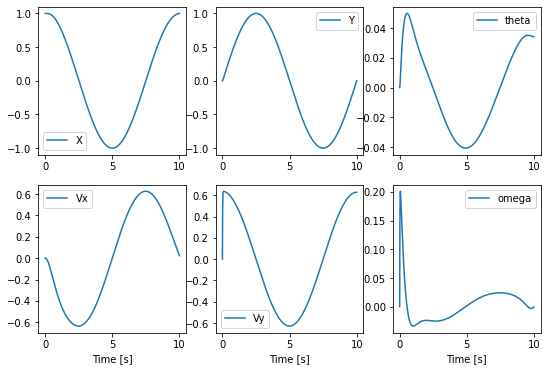

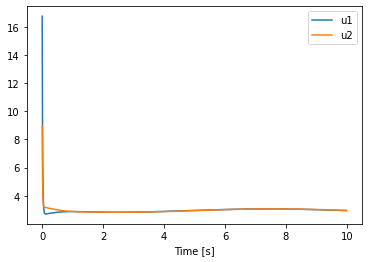

In [11]:
plot_result(t, state, u)

In [12]:
# Trajectory tracking with disturance

horizon_length = 1000
z0 = np.array([1, 0, 0, 0, 0, 0])
t, state, u = quadrotor.simulate(z0, circular_trajectory_controller, horizon_length, disturbance = True)

quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABV+m1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAANsmWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrh/uMdsT2wAAAK4AFcCRH5
TUC+9Z0+AA5DFVT20SvOEXcqkVG+oEUUd3hUL1RPikzh+tNyTCJsuCHmrmBn5AuUCSyHPOBK25Sk
yW06sM0eGJd5HI2Jynyo3CN+2yi9zhGTFwnGMNpmshhxkITraf6H24P/9vvrBhkYCWoHt3t6dXCe
L8BC76nAQM50lo5vbhOvWz3BBKscx/8oJxuZbP5e6AjjaTx4uTBfm7X3q6/Ac5q+rTMyRkH/84f4
hrwM1D0thoHvdn9scBxannhVyNZ+SidLSd3kpnn+JuasMWjYEmm9hzXuW7cC8MfdjHF93j9EcQac
caYyWHh19n4QsejRdf5jyoBygxOcg5EeP2V50URibAkvVHetCgAAwNWpU92dYn+gUXFOE/1CnX4E
Rw82/bkSOdqwgAR5ozMmD0v7peaHJiIdmu+A2opuXi2MyoR2+7r+Z3jQHe0GqpnFRoWpzahMo53q
W/eQjhdiLpq5MX6d9HxPCvn0bf4Uimk4BYwU+gNnsd2eLQ+mwN8Bd2n8XGrqbXeeR3xeTigVTTUK
VHZjSnlHysodh1xFr3il0JoBvv/Tojdehn7Wk57Jrj0UhzAv9jJaqKJCs910kLQsK4qwnU5F44Zv
kaeJwDpRT8sf3o/DfCzopP0CfSNhPBmEsctPqKPwSAAneBI8DUStySjGMiuPznZty/KUEDwjE/Es
W9P77wp9q8/Drv7PD+D1T89iBYkMGXYD1nQ9YuFAGl1oPJNxiWMmX0aV1NZBNAH0W/sAAAMAAEH9
f0TZuUdABVNDqpHdrtc1MZ7gHweNq4GB1z+vQQZ8FOfHDJDkVwt97Mmgg3tp4BAtqzKCMVW9RVap
NAmApkwjcA4w8lCRP6XmbE2mgrKQdY6qqoJU7nMsXk3tHutZdtXJ3fhx0oy6ldP/ixLO01JD0569
TMf/4AmQ8lPi+X7aCrJGtTJGvXK/pWar0XyQx/gZwIjg4Y4vtgOuirEUyix+trDnK1fd4jvklJH0
FAPRBZ/exS4gdktsVfXwFZsGcETA2Ps9+X9Bw7xrTaw/AU7e+EcQ1UL/3orgY04A8ARfouz+t7Kt
jlYULbx3fpKUSRdjnRRR8Z5qBWyvCFzanguiWwtztS7wAAADAW0LVrN/9zoVwABUWOiThNYH+SHU
CoRM+oo9iev7zBd2OE+FX4oY2xQxxxO8n4/MWLJkKfjI8KcYeP+jIP/3syh8qRLCxHLdAK32sHHu
JQtAPj9e3msXTwX9Hc5w/cMkOLLBikntn651NNfTeOq5BEKBjXFEhBHEA/iss9K70vjAHZMIEUbt
4Gj/58Qb66uq0oIeUwI0XxaL2kUyyyOT16dEku8v5SAmyKxF0WI17aP4uKa/UtKjWiDOHXyklJXm
uoYIlX/RuD/xv8DPoLqO7ysbGTaYOQHviaftfUvqZ1wylHdlNPaz8JHzR+K8xcewI2jLqcN6umJG
KoDEaeYYxMAjxJwGYpohgE7ntdRLMi9J9lWnLNfXzsmbtWAAA2Jg/FgQL17u3KLWIucspy1OyAvG
YRzZ/aOOYKzEn2KDGUI05cOqQYjVZaXWJVbUzfvNptAADa1acdzLrR4QBFVAhKQRhD+LmcHrZqOO
FNRp9u+o5f7CrpI/ZMv8cO7gkO3/F99E2Fvf/r0+hnA7W7+yQBpJiTqiB72BM0Ef/NYEHdVQDov4
AkChNkOtOyKu71XebWmINEC15y6Aowrg7W8NboXdBDrOsghPtywNK1D/NFT/vJt2JNS8hbKYCzFK
7d5wXxOqXYKwXncNpEJ15qjteixBn1jamcbNDpGQ1cCslgIHg0sj6AXsWhDB756Qwzjf53GU0q9v
OqEvZm6CFrE/UfcuScpitSGHrQOglApZZQ2x8Z0gYyj5ZKpIQmzWB3YA73Ekvty8NXXN6iaJw5Ww
+9yfn/t5k8Y6CFyLq5oiqXDs2rLkOhXVoZRywzTDnHxdTVKDGOUdrXSrRGecdlHr/RRDYMlFjC3G
Q/9RpYxj9E8OsBE8Uh2v0JDOR0AhYaMmSYPxbHSPw8ZMCMB5wndE79kjIaDB321+YmZhz0P5czCy
STerUx33xHDUjthrKF1v66TbHkW7y52UHNLMpv3+pe6h692dxYYu4yLYwVqo0MX4mD58DTs/IvV7
Y9rQW/7gSafAAABXO0mB4TJtK+YAAA4JvF2FAjKA7sklN3Lb+ycQdJlh/Ohfo27/oiQmfzwu7Vqi
496vD/E+9YlIgO6Tsf821hi63mFcIjGoYq6NvCiq6d34Ln74yXcuZ7abWzcGmSNUvUmkt6mk2VW7
9OFUdKC+9RDFrpLPf0hm5I1w2yKfFybDb8uZ/Lx3O/cWX/dKZeTreO8WELs/EQ1UZJ9w4i94XMZs
s7nyzBwnXX64Z5/WiObRPbmg4YSevc1AhBdQVpTi8cAnCeEZ23YDPGFNWlsvxRxq5CY6h4knfUo3
smNDBJpqN68rQLnJjENJK3eM/1BSV+2VbNRtoDJHnH7f2ae0byBhQ/ei5lWqqs71zQfeJCdbwAAA
AwAAAwAI851Gswqew5HTzL1uldH36eHc/+hH+I4mHIMbxe9OQ6qzgjr6GuMtBoE3p/X5b7w2LNaa
GjEBQrMB2HUessmhGNM8O3dKJs+xqjmXKypqWrJ0dH/Pxoz3DSaIWqjOxap+QwAAx+6l10xAuvSU
t7ZulWjiwQgG0HUQziN5bF+L+e7+y4jwKx5S0x+BWCo+NkLKakdEMnNHKdyQ+0pPkS4K/ebMh4d0
9C4MjptErTmzBliExf17IGw5sz/zHTvzz+m3LLP/zQrZzsyhU0qPteJUn9hA0P5YVyM17nfkJmF+
YgC6pajLgAAAAwAJhIrfn

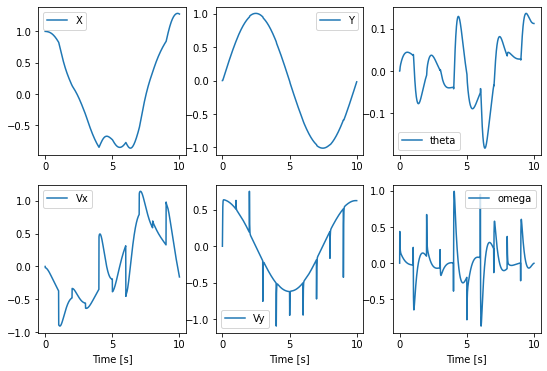

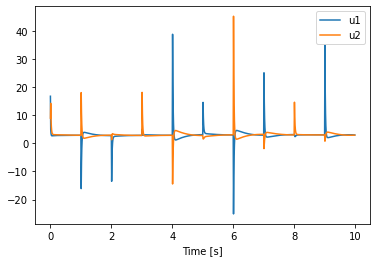

In [13]:
plot_result(t, state, u)

## Part 4: Task 1

In [14]:
# Part 4:
# Task 1: Without trajectory


z_desired = np.array([0,0,0,0,0,0]) # 0-400
z_desired1 = np.array([3, 0, 3, 0, np.pi/2, 0]) #400-500
z_desired2 = np.array([0,0,0,0,0,0]) #500-1001
z_desired = np.vstack((z_desired, z_desired1, z_desired2))
z_desired = z_desired.T

def compute_cost(z, u, horizon_length):
    # iterating cost
    z_des = z_desired
    u_des = np.array([quadrotor.MASS*quadrotor.GRAVITY*0.5, 
                      quadrotor.MASS*quadrotor.GRAVITY*0.5])
    
    J = 0

    for i in range(horizon_length):
        R_gain = 1
        R = np.identity(quadrotor.NUMBER_CONTROLS)*R_gain

        if i<400:
            Q_diag = [5, 2, 5, 2, 2, 2]
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,0]
        elif i>400 and i<500:
            Q_diag = [100, 2, 100, 2, 200, 2]
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,1]
        elif i>500 and i<600:
            Q_diag = [200, 2, 200, 2, 100, 2]
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,2]
        else:
            Q_diag = [5, 2, 5, 2, 3, 2]
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,2]

        J_1 = np.matmul(np.transpose(z[:,i] - z_des_), np.matmul(Q, (z[:,i] - z_des_)))
        J_2 = np.matmul(np.transpose(u[:,i] - u_des), np.matmul(R, (u[:,i] - u_des)))
        J_ = J_1+J_2
        J += J_
    
    # Terminal cost
    J_T = np.matmul(np.transpose(z[:,-1] - z_des[:,2]), np.matmul(Q, (z[:,-1] - z_des[:,2])))
    J += J_T

    return J


def get_quadratic_approximation_cost(z, u, horizon_length):
    Q = [] #N+1
    R = [] #N
    q = [] #N+1
    r = [] #N

    A = []
    B = []

    z_des = z_desired

    for i in range(horizon_length):
        x_k, vx_k, y_k, vy_k, theta_k, omega_k = z[0,i], z[1,i], z[2,i], z[3,i], z[4,i], z[5,i]
        u1, u2 = u[0,i], u[1,i]

        # hessian
        R_gain = 1
        R_ = np.identity(quadrotor.NUMBER_CONTROLS)*R_gain
        
        if i<400:
            Q_diag = [5, 2, 5, 2, 2, 2]
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,0]
            y_des = z_des[2,0]
            theta_des = z_des[4,0] 
        elif i>400 and i<500:
            Q_diag = [100, 2, 100, 2, 200, 2]
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,1]
            y_des = z_des[2,1]
            theta_des = z_des[4,1] 
        elif i>500 and i<600:
            Q_diag = [200, 2, 200, 2, 100, 2]
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,2]
            y_des = z_des[2,2]
            theta_des = z_des[4,2]
        else:
            Q_diag = [5, 2, 5, 2, 3, 2]
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,2]
            y_des = z_des[2,2]
            theta_des = z_des[4,2] 

        # jacobian
        q_ = np.array([Q_[0,0]*x_k - Q_[0,0]*x_des,
                       Q_[1,1]*vx_k,
                       Q_[2,2]*y_k - Q_[2,2]*y_des,
                       Q_[3,3]*vy_k,
                       Q_[4,4]*theta_k - Q_[4,4]*theta_des,
                       Q_[5,5]*omega_k])

        r_ = np.array([2*R_gain*u1- R_gain*quadrotor.MASS*quadrotor.GRAVITY,
                       2*R_gain*u2- R_gain*quadrotor.MASS*quadrotor.GRAVITY])

        A_, B_ = get_linearization(z[:,i], u[:,i])

        Q.append(Q_)
        R.append(R_)
        q.append(q_)
        r.append(r_)
        A.append(A_)
        B.append(B_)

    # terminal QN qN
    Q_diag = [5, 2, 5, 2, 3, 2]
    QN = np.diag(Q_diag)
    Q.append(QN)

    qN = np.matmul(-QN, z[:,-1])
    q.append(qN)

    return Q, R, q, r, A, B


def solve_iLQR(A, B, Q, R, q, r, N):
    K_gains = []
    k_feedforward = []
    Pn = []
    pn = []

    QN = Q[-1]
    qn = q[-1]

    Pn.append(QN)
    pn.append(qn)
    
    A.reverse()
    B.reverse()

    for i in range(N):
        u_ = np.array([0.5*quadrotor.MASS*quadrotor.GRAVITY,
                       0.5*quadrotor.MASS*quadrotor.GRAVITY])

        Kn1 = np.matmul(np.transpose(B[i]), np.matmul(Pn[i], B[i])) + R[N-i-1]
        Kn1_inv =  np.linalg.inv(Kn1)
        Kn2 = np.matmul(np.transpose(B[i]), np.matmul(Pn[i], A[i]))
        Kn = np.matmul(-Kn1_inv, Kn2)

        Pn1 = Q[N-i-2]
        Pn2 = np.matmul(np.transpose(A[i]), np.matmul(Pn[i], A[i]))
        Pn3 = np.matmul(np.transpose(A[i]), np.matmul(Pn[i], np.matmul(B[i], Kn)))
        P_n = Pn1 + Pn2 + Pn3

        K_gains.append(Kn)
        Pn.append(P_n)

        # Feedforward
        kn1 = np.matmul(np.transpose(B[i]), np.matmul(Pn[i], B[i])) + R[N-i-1]
        kn1_inv = np.linalg.inv(kn1)
        kn2 = np.matmul(np.transpose(B[i]), pn[i]) + r[N-i-1]
        kn = np.matmul(-kn1_inv, kn2)

        pn1 = q[N-i-2]
        pn2 = np.matmul(np.transpose(A[i]), pn[i])
        pn3 = np.matmul(np.transpose(A[i]), np.matmul(Pn[i], np.matmul(B[i], kn)))
        p_n = pn1 + pn2 + pn3

        k_feedforward.append(kn)
        pn.append(p_n)
        
    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward


def get_new_u_z(z_star, u_star, Kt, kt, alpha, horizon_length):
    u = np.zeros_like(u_star)
    z_ = np.zeros_like(z_star)
    z_[:,0] = np.array([0, 0, 0, 0, 0, 0])

    for i in range(horizon_length):
        u_ = np.array([0.5*quadrotor.MASS*quadrotor.GRAVITY,
                       0.5*quadrotor.MASS*quadrotor.GRAVITY])
        u[:,i] = Kt[i]@(z_[:,i]-z_star[:,i] ) + alpha*kt[i] + u_star[:,i]

        z_[:,i+1] = quadrotor.get_next_state(z_[:, i], u[:,i])

    u_star_new = u
    z_star_new = z_
    return z_star_new, u_star_new


N = 1000
z0 = np.array([0, 0, 0, 0, 0, 0])
u_star = np.ones([quadrotor.NUMBER_CONTROLS, N])
z_star = np.zeros([quadrotor.NUMBER_STATES, N+1])

alpha = 1.0

for epoch in range(120):
    # forward pass
    z_star[:,0] = z0
    for i in range(N):
        z_star[:, i+1] = quadrotor.get_next_state(z_star[:, i], u_star[:,i])

    J_old = compute_cost(z_star, u_star, horizon_length=N)

    Q, R, q, r, A, B = get_quadratic_approximation_cost(z_star, u_star, horizon_length=N)

    # Backward pass
    Kt, kt = solve_iLQR(A, B, Q, R, q, r, N=N)        

    z_star_new, u_star_new = get_new_u_z(z_star, u_star, Kt, kt, alpha, horizon_length = N)
    J_new = compute_cost(z_star_new, u_star_new, horizon_length=N)
    if J_new<J_old:
        J_old=J_new
    else:
        alpha = alpha/2
    u_star = u_star_new
   
quadrotor.animate_robot(z_star, u_star)


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABQxW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAN5GWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0AKyEiQN
GoF960K8QBVQ5o4JP/2cuv2ZMrH9QQZc0jHnLNGnVOHM8XVrtwE5+h5X2tZb0yVcBXic84ErblKT
JbTq4Hd8Yl3kcjYo0GwN0gX5v37991BsXCcYw2mayGViX7BEgxkPtwf//psTT/eDe8rLOmldMX+X
tWN3jEkYZZzhIObepWqsJ+HoYBGdkTf9P/7uKEXXC2I74+6w0Zx+XG+zlXFXgwxm5Qz+KIqvNFkD
lUP5L0XF+hp7Uk8n9kpANbcgjSMpLW7m5TbNsYTwsM95H9qz+EvI708ahHUu6vK+1J58JMjWbbIn
Zn4IBKAAC7g6U1KoDtjcnP58qNj/JoDC5fVtr+A2m5QAIeNCly0DokANHk14UjVOPHT/bRdMMLhc
HeFBpVmWjUZPnDxEPxnmdAd7QaqoofCuNL7WRoMmUl/wpZbIKnYPO0DFA4GiewEgMg2/wpFNJwCw
3zvnJ0b32ZekpfXy2tSyvQd0NcE2x6+cNbN/5vLsdqyWlRw2QlFf8t/MUhDvNJPuPJ+Lnk+q+lQ4
eLo4KJc22S4/Xf+PY3equSdAKXPmUb7EdE2jhDuW/KNLo0niDiIJITmoYuC6VeG1cCu4Xv2VqNhL
gJbIE/MAN9GWy8MVq3JKMY05hpbR65Dk/eLsdAxzBAr2oVxGFkT/PhGfZthbWxjPO1OT5VOuHlGm
wU1d1p7J9Af9kY7lGkBHkYrI4yusPcYU4XXkiBBXmfdpxQAAAwC1CZjMyK5c22YBdQlKgl1KkcCs
RxULvj07lJvaE/1ct0s6EBTwzE+UWupyGTX9vO345aNs/wNQ/4V1buvVOI0dQeS4BxhhX5mv0vM2
JtNBWPRyaS1ECKPL6/MdozqIzwP6cnd+HHSisYEZeG0gIqUymPTnr1IxP/pBgmgm8BFStWTTHjLM
xQ60cYl1K4e1m3hC1onBHBwxxfWgha5UF0IMM7kaLaR+4aoPADApQhIzR07n9XFZae/M2xV9fAVm
wZw2MimGG+s+AyO59vHrTaHisD7u+EkA3Ul/6VA0wSQX49hJgXZ/W9lWxysKFt79X7H/yAfTI/kR
453FbNp/3gKU6XOuXYELBUYCR677xzJY8jBmACGX1+MAeK/zsGszd6cnq6six0ScJrA/yQ6gVCJw
1FHsT1/eYLuxwnwq2FjG2KGOOJ3k/H5hb2yUgcAywdjDyNNVP/+5WjXxTwGKM39c6h3KsNG3BKR/
2f5Zm94NXMcR2btFeVoHe+lqFGdc3Rur0KNjhGNCWhpWEMw8pssX+KCzr9LrG37Wwf24qaaCTw0Z
/z5A32oReNpWIzxpovi6haz8Nlkcnr06H6R82KmIgEVY+HviT/0mCXkg/0e3Ki6u93g+xQXNwAdC
L2bBnn4e/8MXl3VmOay10svjSAqS3/UgPrrmR7boiskFuWpptXKznr+YxsPAen/dN+V2dN1MWvrk
amWBkH6TO+oIxNZZR49xmILJ/a1cSf1dgAAAAwABv0ZV22YaXCy0lY0QuSjdgkHUBSohKIgw3izh
pDbbZKspw35Pp5UjNrAWBdGctP/kwyVc21icCC+guEk/5AD00D/BZ6uwvM+tvqVzR5/fIWkD0SxX
YPrAoK4nmStG2C8JYNbVZTkMtbxvJu8H2geF/VaItbwczrU/vFhJDxF6h+q3WQTtiLF42aBqkJPQ
pTrswJNvLd3VhPqoAV88tpPfFK3PDXd//PoSzIl0jkQ5K+YyRZs8vEv9ZC0jqTVc6kuZxLTswaI3
Xlq7XkgodadP79EFlFCqxi0KUTrkW1bTeQtwdj4kYCiFg6vKWRMxJxJLMxK6jRcMX9B04oVfW4kK
Y1dQmc5Uw2d2b0cmnzU8EmOZ0qsnVy2EiBSS94FgefdGBpiaXMrlsnLkOhXatq+o1iWSIWps/nJT
nRjQPChSPoUxusgUiFt9gMnnI+xfi9CE/sdJt5medctOsa4vjZCympHRQYR2Xd0uBHz8dcVGyj9M
9Fdm+rLSmDB8ljZg430YNitKoSLP0Qf46l39Du5DnCTaLPC/DZ4XzgPY1K4/7LZmwTgMkfXXgPlo
eSI5uCBZPokEE/EUcMGcGXqlS+3NAwoels0DmrXEOf7x2I1++F6AVTMy9YpUhipHOR/ss/uOQnYH
6yYVnZMXCf4SjUAAB7AAAOodGM15Q1sDbYdvQSuQL5lBNxF/cEM8/OmwPhYtKPuOzOapxXDhh8R3
SNtSYg7H/NtYYut5QbnKh4UkT4hrJA107vwXPXWlFXcer491uGH5GqXoWmuszSbKrd+nCqTR3nO5
wlkdWHv5/wQTiyKQek/9/GuiOROpc+5by3Xfw/DGs6ciGNM//YSiZD2kEytS4C5lf1wtUCw/1kb2
Fj/zg+9sFlX4pJSWIvNzPM8RMxGMLEC/fX9eIjTk3vCyuWY1uP5SVQxo7fZUbzuzR+NpizmhPKC5
TuRNKLkVMast/52pypEsdr1tg4bpIR7ohg+Pw+2tR7Mid011qAd0oFjCt2jrUlIn8RdnrE8BCgIy
XhuVv0AnOSnXcCVRe8G0vhUevipRHr0senM4T1hr/s6aFv5Ap+QwnroJMmNDREqXJc1RPcdsSY5f
k+SgpECy5289AkWsiK0iWrLpBQrswE9f8VmAvOvMv8lfwMgx3xzRquXiuDCfcKxKkc/o67d6L4ac
sQqAwBVZgCpuRLp2g6LUYxgPIwuPzfw+BgXXnVRJ7febL+dvPR3w34YrZD1EthDtfoSGcjoSuXUX
QI8JQ1Mk7LsNfh1UaSMwdgPhp6bfVOp9iLhh2hyFZiZwB1Z3nU1QtZk1qzdFYMDYiSdtZXkRwKGS
Hwig+r/r1ttzUWFnEFmG6

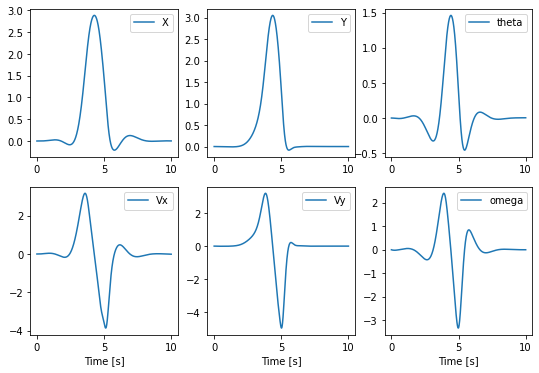

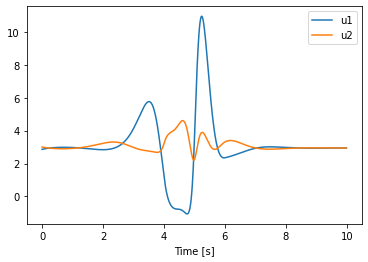

In [15]:
# Plotting a result

z0 = np.array([0, 0, 0, 0, 0, 0])
def trajectory_controller(state, i):
    u_star[:,i]
    return u_star[:,i]
t, state, u = quadrotor.simulate(z0, trajectory_controller, horizon_length=1000, disturbance = False)

plot_result(t, state, u)

## Part 4: Task 2

In [16]:
# Part 4:
# Task 2 - doing a full flip

z_desired = np.array([0,0,0,0,0,0]) # 0-400
z_desired1 = np.array([1.5, 0, 3, 0, np.pi, 0]) #400-500
z_desired2 = np.array([3, 0, 0, 0, 2*np.pi, 0]) #500-1001
z_desired = np.vstack((z_desired, z_desired1, z_desired2))
z_desired = z_desired.T

def compute_cost(z, u, horizon_length):
    # iterating cost
    z_des = z_desired
    u_des = np.array([quadrotor.MASS*quadrotor.GRAVITY*0.5, 
                      quadrotor.MASS*quadrotor.GRAVITY*0.5])
    
    J = 0

    for i in range(horizon_length):
        R_gain = 1
        R = np.identity(quadrotor.NUMBER_CONTROLS)*R_gain

        if i<400:
            Q_diag = [5, 2, 5, 2, 2, 2]
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,0]
        elif i>400 and i<500:
            Q_diag = [100, 2, 100, 2, 200, 2]
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,1]
        else:
            Q_diag = [20, 2, 20, 2, 100, 2] #[5, 2, 5, 2, 50, 2] 
            Q = np.diag(Q_diag)
            z_des_ = z_des[:,2]

        J_1 = np.matmul(np.transpose(z[:,i] - z_des_), np.matmul(Q, (z[:,i] - z_des_)))
        J_2 = np.matmul(np.transpose(u[:,i] - u_des), np.matmul(R, (u[:,i] - u_des)))
        J_ = J_1+J_2
        J += J_
    
    # Terminal cost
    J_T = np.matmul(np.transpose(z[:,-1] - z_des[:,2]), np.matmul(Q, (z[:,-1] - z_des[:,2])))
    J += J_T

    return J


def get_quadratic_approximation_cost(z, u, horizon_length):
    Q = [] #N+1
    R = [] #N
    q = [] #N+1
    r = [] #N

    A = []
    B = []
    z_des = z_desired
    for i in range(horizon_length):
        x_k, vx_k, y_k, vy_k, theta_k, omega_k = z[0,i], z[1,i], z[2,i], z[3,i], z[4,i], z[5,i]
        u1, u2 = u[0,i], u[1,i]

        # hessian
        R_gain = 1
        R_ = np.identity(quadrotor.NUMBER_CONTROLS)*R_gain
        
        if i<400:
            Q_diag = [5, 2, 5, 2, 2, 2]
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,0]
            y_des = z_des[2,0]
            theta_des = z_des[4,0] #np.pi/2  
        elif i>400 and i<500:
            Q_diag = [100, 2, 100, 2, 200, 2]
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,1]
            y_des = z_des[2,1]
            theta_des = z_des[4,1] #np.pi/2
        else:
            Q_diag = [20, 2, 20, 2, 100, 2] #[5, 2, 5, 2, 50, 2] 
            Q_ = np.diag(Q_diag)
            x_des = z_des[0,2]
            y_des = z_des[2,2]
            theta_des = z_des[4,2] #np.pi/2

        # jacobian
        q_ = np.array([Q_[0,0]*x_k - Q_[0,0]*x_des,
                       Q_[1,1]*vx_k,
                       Q_[2,2]*y_k - Q_[2,2]*y_des,
                       Q_[3,3]*vy_k,
                       Q_[4,4]*theta_k - Q_[4,4]*theta_des,
                       Q_[5,5]*omega_k])

        r_ = np.array([2*R_gain*u1- R_gain*quadrotor.MASS*quadrotor.GRAVITY,
                       2*R_gain*u2- R_gain*quadrotor.MASS*quadrotor.GRAVITY])

        A_, B_ = get_linearization(z[:,i], u[:,i])

        Q.append(Q_)
        R.append(R_)
        q.append(q_)
        r.append(r_)
        A.append(A_)
        B.append(B_)

    # terminal QN qN
    Q_diag = [20, 2, 20, 2, 100, 2] #[5, 2, 5, 2, 50, 2] 
    QN = np.diag(Q_diag)
    Q.append(QN)

    qN = np.matmul(-QN, z[:,-1])#z_des)
    q.append(qN)

    return Q, R, q, r, A, B


def solve_iLQR(A, B, Q, R, q, r, N):
    K_gains = []
    k_feedforward = []
    Pn = []
    pn = []

    QN = Q[-1]
    qn = q[-1]

    Pn.append(QN)
    pn.append(qn)
    
    A.reverse()
    B.reverse()

    for i in range(N):
        u_ = np.array([0.5*quadrotor.MASS*quadrotor.GRAVITY,
                       0.5*quadrotor.MASS*quadrotor.GRAVITY])

        Kn1 = np.matmul(np.transpose(B[i]), np.matmul(Pn[i], B[i])) + R[N-i-1]
        Kn1_inv =  np.linalg.inv(Kn1)
        Kn2 = np.matmul(np.transpose(B[i]), np.matmul(Pn[i], A[i]))
        Kn = np.matmul(-Kn1_inv, Kn2)

        Pn1 = Q[N-i-2]
        Pn2 = np.matmul(np.transpose(A[i]), np.matmul(Pn[i], A[i]))
        Pn3 = np.matmul(np.transpose(A[i]), np.matmul(Pn[i], np.matmul(B[i], Kn)))
        P_n = Pn1 + Pn2 + Pn3

        K_gains.append(Kn)
        Pn.append(P_n)

        # Feedforward
        kn1 = np.matmul(np.transpose(B[i]), np.matmul(Pn[i], B[i])) + R[N-i-1]
        kn1_inv = np.linalg.inv(kn1)
        kn2 = np.matmul(np.transpose(B[i]), pn[i]) + r[N-i-1]
        kn = np.matmul(-kn1_inv, kn2)

        pn1 = q[N-i-2]
        pn2 = np.matmul(np.transpose(A[i]), pn[i])
        pn3 = np.matmul(np.transpose(A[i]), np.matmul(Pn[i], np.matmul(B[i], kn)))
        p_n = pn1 + pn2 + pn3

        k_feedforward.append(kn)
        pn.append(p_n)
        
    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward


def get_new_u_z(z_star, u_star, Kt, kt, alpha, horizon_length):
    u = np.zeros_like(u_star)
    z_ = np.zeros_like(z_star)
    z_[:,0] = np.array([0, 0, 0, 0, 0, 0])

    for i in range(horizon_length):
        u_ = np.array([0.5*quadrotor.MASS*quadrotor.GRAVITY,
                       0.5*quadrotor.MASS*quadrotor.GRAVITY])
        u[:,i] = Kt[i]@(z_[:,i]-z_star[:,i] ) + alpha*kt[i] + u_star[:,i]

        z_[:,i+1] = quadrotor.get_next_state(z_[:, i], u[:,i])

    u_star_new = u
    z_star_new = z_
    return z_star_new, u_star_new


N = 1000
z0 = np.array([0, 0, 0, 0, 0, 0])
u_star = np.ones([quadrotor.NUMBER_CONTROLS, N])
z_star = np.zeros([quadrotor.NUMBER_STATES, N+1])

alpha = 1.0

for epoch in range(120):
    # forward pass
    z_star[:,0] = z0
    for i in range(N):
        z_star[:, i+1] = quadrotor.get_next_state(z_star[:, i], u_star[:,i])

    J_old = compute_cost(z_star, u_star, horizon_length=N)

    Q, R, q, r, A, B = get_quadratic_approximation_cost(z_star, u_star, horizon_length=N)

    # Backward pass
    Kt, kt = solve_iLQR(A, B, Q, R, q, r, N=N)        

    z_star_new, u_star_new = get_new_u_z(z_star, u_star, Kt, kt, alpha, horizon_length = N)
    J_new = compute_cost(z_star_new, u_star_new, horizon_length=N)
    if J_new<J_old:
        J_old=J_new
    else:
        alpha = alpha/2
    u_star = u_star_new

    
quadrotor.animate_robot(z_star, u_star)


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABauW1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTkgbG9v
a2FoZWFkX3RocmVhZHM9MyBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAN8WWI
hAAR//73iB8yy2n5OtdyEeetLq0fUO5GcV6kvf4gAAADAAADAADkqv9vvWY/opvgAAAV0AKyEiQN
GoF960K8QBVQ5o4JP/2cuv2ZMrH9QQZc0jHnLNGnVOHM8XVrtwE5+h5X2tZb0yVcBXic84ErblKT
JbTq4Hd8Yl3kcjYo0GwN0gX5v37991BsXCcYw2mayGViX7BEgxkPtwf//psTT/eDe8rLOmldMYEH
c6oj5Y+lHShjvew4YzHn3hefC2vqjbplJ68h//dx4ZTIH1BVgKe6McmgG49sDid6Yq5tA2cTF3RY
1dVpzQNHA8SP9eIwctx4qZge1K0igJwr0MPsN+EmvCqsCeGeCH3kV8k8CY36bIOcUTaAO9jF2gX6
Y3w68HBDb/bLnCHNvRP6bEPJELLFq0ocECwny0iHAABGTxRdiRLmK/7M2wKngkFAQvu02kZCEV4+
JMYSoAYyGnP9aX1y2bquTEQ7Nd8BtRTcvFsZPaIgpc53Lwhztnn5Vpr3p1X5wqyW1mxGtQj4abet
F01cmL9O+j4ngz36se3FNYcztZ5eJ85Oje+zL0lL7HHgOHPPUQa8ShgvdZw1s3/m8ux2KtvwcCiO
26Hp3aSN2MqaSfceDcQfRjTyWsGuLo4KJc22S5A1/8tBIicI81ALem1Uc1luQCjhDuW/KNLo0iEv
Iz+KWeEfUGw9AEj2YXC6FOJbjOW4a2PtKYAw9PXPA1ErckoxhibkA5y/HNM6urLdifiWLen99tBD
xQUwaGVCHIuZgmkN7ChF5PvcNuKKf0s9lYnuskgYx3KNICPJhyyOMrrD3rAhDvP/5QAnlj6BIN7o
tKQAAAMAMUAS3Dd9u9bhYSQEdSQ70wPXUSYylBeNY3TtzNLR909ZbpZ0CGoaGJ8otdTkMmv7gdvx
y0bZ/gah/vp8mP9U4jR1B5LgHGGwWma/S8zYm00FXvYWGdaMWV6Y06aoRxJby2qcnd+HHSgPtxGn
d8REVKZTHpz16kQ3/sBKLQdaAe+AhW+OZ+UhQ60bOMbeTS/LqN8DOBEcHDHF5xn3HM/KwgwzuRot
pH3neJOHwAKEJGaOnc/XXQcWPcll9q7KCMFaayi0S295fL+g4ZIKnzQi5qQsLj2P4IXbYWn/n3u3
e0vwbw5ii7P63sq2OVhQtnSMrcZaEmzrCpL6XMiVLpIEPgAQsBE/E14OJ2Wg7L8AAAMAAA5WmENU
0GPP6ag26luqHOdQw976KR5hkt4iR55Fm2hgu7HCfCpatmGJU/J5qzpyx4xNkyFPxkeFOMPHuPU/
/7mtQ+VIlhYjltuEr7WDj3EoWgHx++c3zvn7U4wuCy1Tf6KzKU95/XOFvOpSIIbx1XIIhQHwAXFN
li8fs+ZXF1qo+MAdkwgRRu3fIP/nxBvqitgKg2cNv6J+5j/jopllkcnr06H6a9Qp9UrIyBLGO+6A
g76b6iM/luVF1d7vB9igdbkepHUPskbtcpXkFLaBqzHNZa6mXypACKg7QiTAYsWhcalaj39FINNq
5Ylnv56pG9VPB7E+Ku1lvWPoEgbchI4xicyBrtB5Y+qQuAHndiYdE3572So9KKskAAADAB0pnq/s
qLu3G5/Lhz4Ez3VdAIoFt/KlEAnIkvcHBwqDQEx2dmV70yXxT4SypZ/afkC/hassX17i+53C9o//
KRkq5trglnrgP+63/o27zQD8Fnq7C8z62+p22BD1DZhTAiCquwfWBQVxPMlaNsF4Swa2qynIZa3j
awxjWnoP7epFjazIzz42tyqieRUi9Q/VbrIBMB1XtDqBqahPQpTrswJNvLd3VhPqnmV2qLrzbRE4
vcgpp/uL74qhXFS7Wsv/5nAJyWb/8pFr80qJc6kuZxLTswaE9/lDSvJBQ606f36ILKKFVjFoUonX
Itq2m8hbg7HxIwFELB1eUsiZiTiSWZiV1Gh9E0VCNatySFxLa61QhM5yphs7s3o5NPWp4JMczpVZ
OrlsEgym6G24IF19nqFOtTUHEKcuQ6Fdp7r6e+HPljwzdP0EsGTFgwQ1rXSrRH7nVFItizAUEv8F
L8XoHf9jpNvMsPDnw2bXF8bIWU1I6KItfzyp1mH+vtMluzV8tUjX0TkT7caNTZ56KNwxsql226gz
Af+Zr+QCemUkvkwMwwDfShYrbAI0yCh4BbfuHgqFblWjzAKnwOtz2Nd+HNGUDH9p1JfP8aiZ9A6A
QzE7hsvdNxEogSvnbrQejDg809wacca7nFx6ki9gX8tYZX3LkAe/rHbnunADIAAApC7+Z2ggEDeS
HUN1yqkq5+2p4L9gTuO/XYtdxCQoEt/DW892wq+fiPA0krqpNSTJtrDF1vJMKO117wT+EJ2wGund
+C5tdqWaWXyBC3IfpKCOIlbOS8AAbXbWFcoVSchfx3OEsjqw9/P+EMbCMeR34QP9dcG1y97PpsW9
PsL8PwxrOnIhjTP/9qvuPTOzANLmT86rt7DS/FH7KN7Cx/8EFTuimr8cgJLEXm5nmeImaVGUpaBV
lwwg6OiJveFlcsxtdHNtksKQbzVM3YRaSVYVsp6Gdt3FYsVd0xOCNh8tKCX/ugpmEjVlu+AcSebf
m619y4/icn/1vWy1DLVsWS9euPfVlRynqb3JA6LuHbzpziBee4o5m2nMR+oNxKhoKkvgZZbuTOiB
tfvNUT93jfQXndD+EYZImQYrebSoPhdoKEuaonuO2JMcvyfJQUfxcCN8/jOLWRFaRLVl0fccvV7f
HXPK+f2Mf37mjjsERIt6eZFrxXBhPz3YlSOf0ddu9F8NOVzzJHnIg5rgErq08HQpH0KZCu+J5HtA
G+r8QyUWMLcGn9zU3+dqtYIrZIUE7Z91QN5DOR0S5Joe/aOQ01G2BkV6oUN088V4Nv2wg1nva2cf
2mCwBl1YLm2hCvRAgcJkW

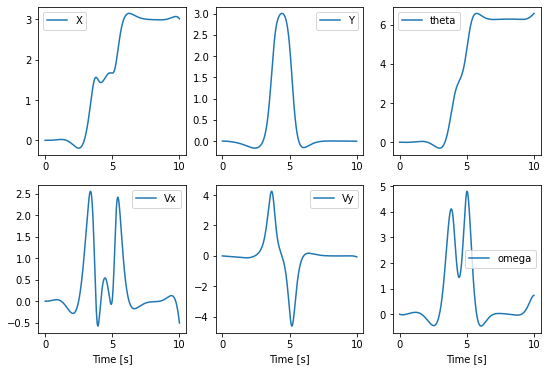

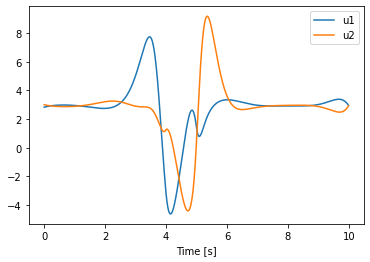

In [17]:
# Plotting a result

z0 = np.array([0, 0, 0, 0, 0, 0])
def loop_trajectory_controller(state, i):
    u_star[:,i]
    return u_star[:,i]
t, state, u = quadrotor.simulate(z0, loop_trajectory_controller, horizon_length=1000, disturbance = False)

plot_result(t, state, u)